# Import libraries

In [1]:
import re
import nltk
import numpy as np
import pandas as pd

import collections
import wordcloud
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn import (
    model_selection,
    metrics,
    feature_extraction,
    decomposition,
    ensemble,
    tree
)

import tensorflow as tf

In [2]:
SEED = 42

# Data Reading & Processing

In [3]:
dataset = pd.read_csv('sentiment_tweets3.csv')
dataset.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


#### change the name of columns to more easy

In [4]:
dataset.rename(columns={"message to examine": "messages"}, inplace=True)
dataset.rename(columns={"label (depression result)": "labels"}, inplace=True)

#### take only the messages & labels columns

In [5]:
dataset = dataset[['messages','labels']]
dataset.head()

,messages,labels
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


#### labels value

In [6]:
dataset.labels.value_counts()

0    8000
1    2314
Name: labels, dtype: int64

Text(0.5, 1.0, 'COUNTS OF CATEGORIES OF BEING DEPRESSED OR NOT')

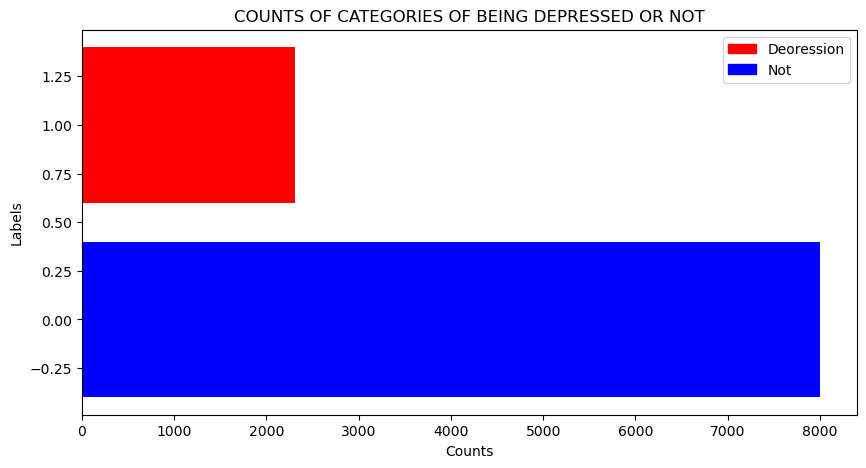

In [7]:
fig = plt.figure(figsize =(10, 5))
plt.barh(dataset.labels.unique(), dataset.labels.value_counts(), 
         color =['blue', 'red'])

colors = {'Deoression':'Red','Not':'Blue'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)


plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("COUNTS OF CATEGORIES OF BEING DEPRESSED OR NOT")

## Clean text

In [8]:
context = dataset.messages

def cleaning_text(text):
    text = text.lower()
    text = re.sub("", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("\n", "", text)
    text = re.sub(r"[^\w]", " ", text)
    text = re.sub("\w*\d\w*", "", text)
    text = " ".join(filter(lambda x: x[0] != "@", text.split()))
    return text

dataset.messages = dataset.messages.map(cleaning_text)

## Remove Stopwords

In [9]:
stopwords = nltk.corpus.stopwords.words('english')

dataset["messages"] = dataset['messages'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

## word most frequent

In [10]:
most_used_words = []
for word in context: 
    word = word.split(' ')
    most_used_words.extend(word)

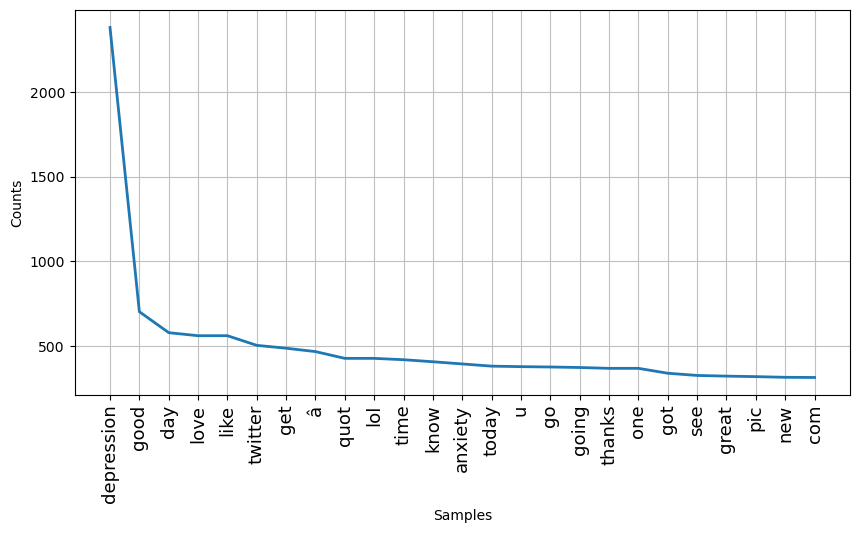

In [11]:
plt.figure(figsize = (10, 5))
plt.xticks(fontsize = 13, rotation = 90)
fd = nltk.FreqDist(most_used_words)
fd.plot(25, cumulative = False)

## Word Cloud

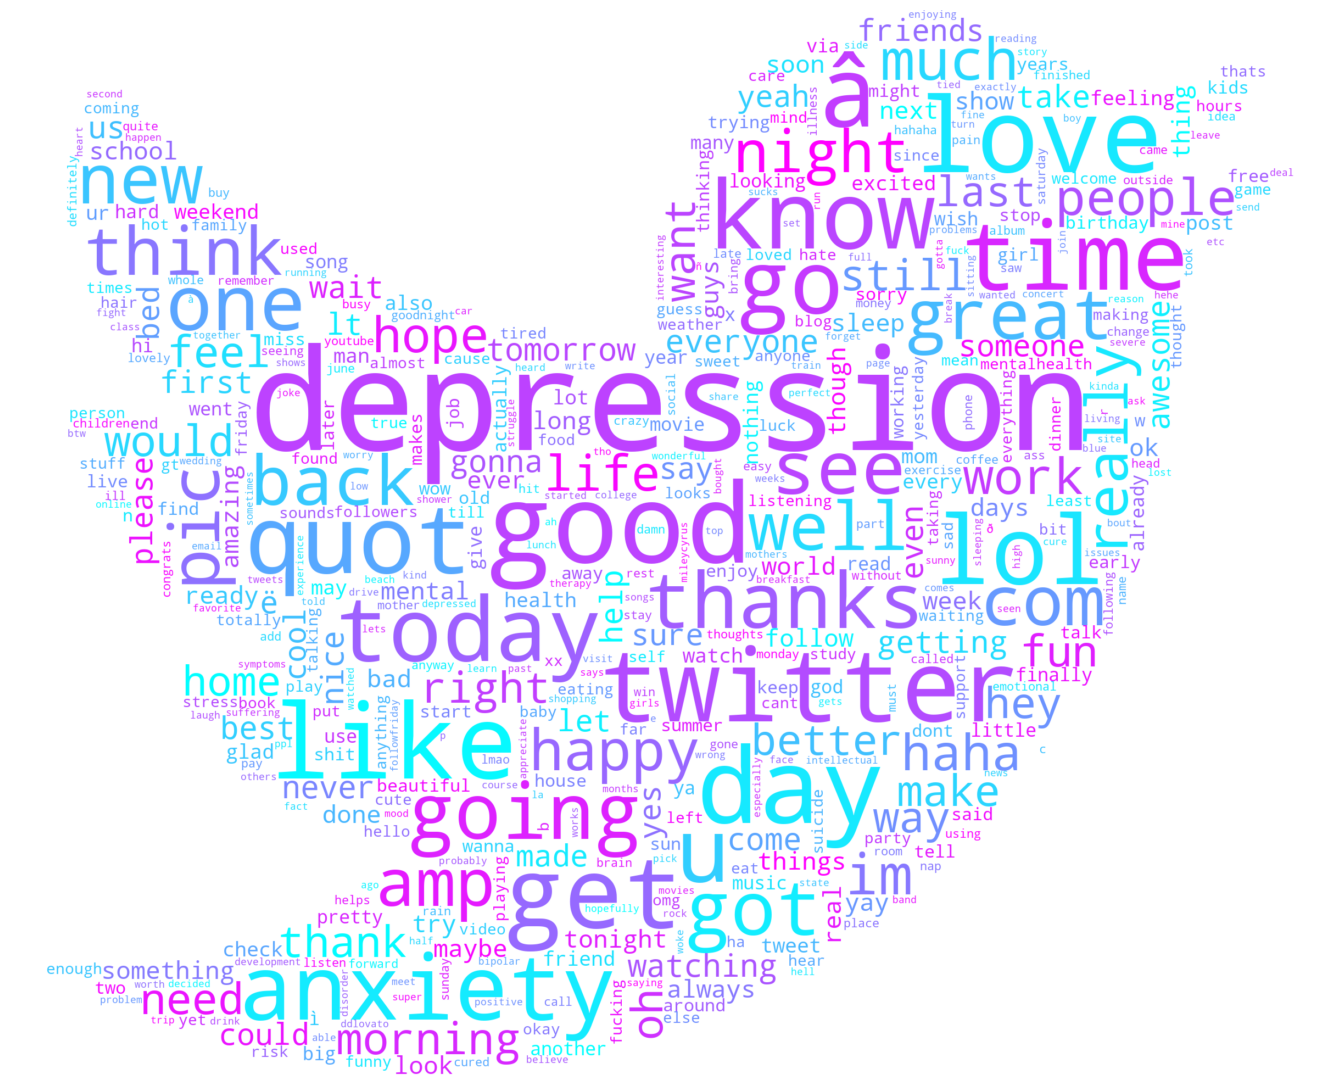

In [12]:
wordfreq = collections.Counter(most_used_words)

IMAGE =  r'twitter.png'

mask = np.array(Image.open(IMAGE))
wordcloud = wordcloud.WordCloud(width = 900,
                      height = 500,
                      max_words = 500,
                      max_font_size = 256,
                      mask = mask,
                      background_color = "white",
                      random_state = 42,
                      stopwords=wordcloud.STOPWORDS,
                      relative_scaling = 0.3,
                      colormap = 'cool',
                      repeat = False,
                      normalize_plurals = True).generate_from_frequencies(wordfreq)

plt.figure(figsize = (17, 14))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Tokenize text

In [13]:
corpus = dataset.messages.tolist()

print("Total number of words in corpus are:", len(corpus),'\n')

Total number of words in corpus are: 10314 



In [14]:
vectorizer = feature_extraction.text.TfidfVectorizer()
vectorizer.fit(corpus)

TfidfVectorizer()

In [15]:
message_vector = vectorizer.transform(dataset.messages).toarray()

#### plot vector in 2D


 Labels from message vector : 



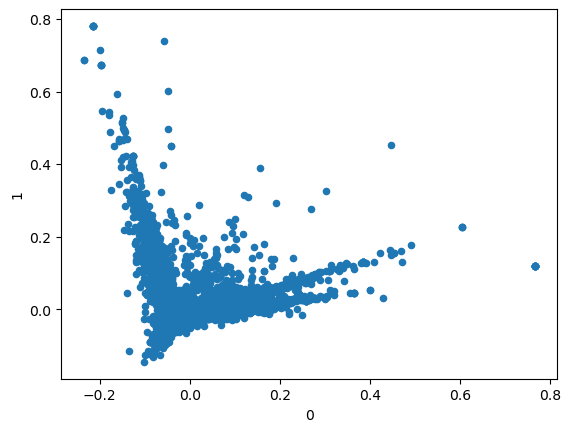

In [16]:
pca = decomposition.PCA(n_components=2)

df2d = pd.DataFrame(pca.fit_transform(message_vector), columns=list('01'))

print('\n','Labels from message vector : \n')

df2d.plot(kind='scatter', x='0', y='1')
plt.show()

## Split Data

In [17]:
x = message_vector
y = dataset.labels

x_train ,x_test , y_train, y_test = model_selection.train_test_split(x,y,test_size=0.2,random_state=SEED)

# Modeling

## Tree Model

In [18]:
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(x_train, y_train)

DecisionTreeClassifier()

In [19]:
tree_y_pred = tree_model.predict(x_test)

## Random Forest Model

In [20]:
randomforest_model = ensemble.RandomForestClassifier()
randomforest_model.fit(x_train, y_train)

RandomForestClassifier()

In [21]:
randomforest_y_pred = randomforest_model.predict(x_test)

## XGboost Model

In [22]:
xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [23]:
xgboost_y_pred = xgboost_model.predict(x_test)

# Model Evaluation

In [24]:
print("THE ACCURACY SCORES OF MODELS :-", "\n")
print("Accuracy Score of Decision Tree Classifier is: ", metrics.accuracy_score(tree_y_pred, y_test), "\n")
print("Accuracy Score of Random Forest Classifier is: ", metrics.accuracy_score(randomforest_y_pred, y_test), "\n")
print("Accuracy Score of XGBoost is: ", metrics.accuracy_score(xgboost_y_pred, y_test), "\n")

THE ACCURACY SCORES OF MODELS :- 

Accuracy Score of Decision Tree Classifier is:  0.9961221522055259 

Accuracy Score of Random Forest Classifier is:  0.9777023751817742 

Accuracy Score of XGBoost is:  0.9951526902569074 



## Confusion Matrix for Decsition Tree Model

The number of true positives are: 1614 

The number of true negatives are: 441 

Confusion Matrix for Decision Tree Model 



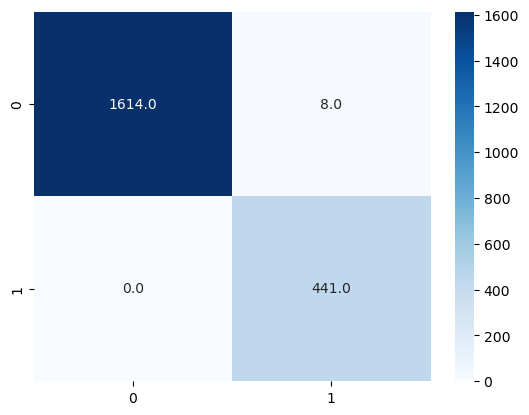

In [25]:

confusion_mtx = metrics.confusion_matrix(tree_y_pred, y_test)

print("The number of true positives are:", confusion_mtx[0,0], "\n")
print("The number of true negatives are:", confusion_mtx[1,1], "\n")
print("Confusion Matrix for Decision Tree Model",'\n')

sns.heatmap(confusion_mtx,annot=True,cmap='Blues',fmt='.1f',)
plt.show()